<a href="https://colab.research.google.com/github/kenrp8/Coursera_Capstone/blob/feature%2Fkenrp%2Freports/Final_Assignment/Copy_of_The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle of Neighborhoods

In [23]:
# import libraries

import numpy as np
import pandas as pd
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn import preprocessing
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

We proceede to fetch the respective data.

##Census Data

In [2]:
# Now we are interested in get the Cities Table from Wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Mexico'

#Read the html tables
table_MXN = pd.read_html(url)

#select Cities table
city_data = table_MXN[1]

#Normalize Census information
aux = city_data[['2020 Census']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
aux_scaled = min_max_scaler.fit_transform(aux)

city_data['2020 Census'] = aux_scaled


In [3]:
city_data.head(12)

,Rank,City,Municipality,State,Geo. coordinates,2020 Census,2010 Census,Change
0,1,Mexico City,16 boroughs‡,Mexico City,".mw-parser-output .geo-default,.mw-parser-outp...",1.000000,8851080,+4.05%
1,2,Tijuana,Tijuana,Baja California,32°32′05″N 117°02′37″W﻿ / ﻿32.53472°N 117.04361°W,0.183569,1300983,+39.18%
2,3,Ecatepec,Ecatepec,State of Mexico,19°36′35″N 99°03′36″W﻿ / ﻿19.60972°N 99.06000°W,0.165140,1655015,−0.69%
3,4,León,León,Guanajuato,21°07′11″N 101°40′50″W﻿ / ﻿21.11972°N 101.68056°W,0.158098,1238962,+27.51%
4,5,Puebla,Puebla,Puebla,19°02′43″N 98°11′51″W﻿ / ﻿19.04528°N 98.19750°W,0.153952,1434062,+7.54%
5,6,Ciudad Juárez,Juárez,Chihuahua,31°44′22″N 106°29′13″W﻿ / ﻿31.73944°N 106.48694°W,0.149464,1321004,+13.67%
6,7,Guadalajara,Guadalajara,Jalisco,20°40′35″N 103°20′32″W﻿ / ﻿20.67639°N 103.34222°W,0.136672,1495182,−7.33%
7,8,Zapopan,Zapopan,Jalisco,20°43′14″N 103°23′18″W﻿ / ﻿20.72056°N 103.38833°W,0.122541,1142483,+10.07%
8,9,Monterrey,Monterrey,Nuevo León,25°40′17″N 100°18′31″W﻿ / ﻿25.67139°N 100.30861°W,0.109896,1135512,+0.66%
9,10,Ciudad Nezahualcóyotl,Nezahualcóyotl,State of Mexico,19°24′00″N 98°59′20″W﻿ / ﻿19.40000°N 98.98889°W,0.102142,1104585,−2.89%


In [4]:
def locations(adress_array):
  latitude = []
  longitude = []
  geolocator = Nominatim(user_agent="can_explorer")
  for ads in adress_array: 
    location = geolocator.geocode(ads)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

  return (latitude, longitude)




In general is a clean info but we must to do some changes

In [5]:
#Drop and replace non used values and wrong names
city_data.drop(['Municipality', '2010 Census', 'Rank','Change', 'Geo. coordinates'], axis=1, inplace=True)
city_data['State'] = city_data['State'].replace({
    'Mexico City': 'Ciudad de México',
    'State of Mexico': 'Estado de México'
})
city_data['City'] = city_data['City'].replace({
    'Mexico City': 'Ciudad de México',
})

# City Adress
city_array = []
for c, C in zip(city_data['City'].values, city_data['State'].values):
  city_array.append(c + ', ' + C)

latitude_c, longitud_c = locations(city_array)

city_data['latitude'] = latitude_c
city_data['longitude'] = longitud_c

city_data.head()

,City,State,2020 Census,latitude,longitude
0,Ciudad de México,Ciudad de México,1.000000,19.399705,-99.124816
1,Tijuana,Baja California,0.183569,32.501019,-116.964663
2,Ecatepec,Estado de México,0.165140,19.599408,-99.048728
3,León,Guanajuato,0.158098,21.121860,-101.682508
4,Puebla,Puebla,0.153952,19.043720,-98.198149


In [6]:
city_data['State'].unique()

array(['Ciudad de México', 'Baja California', 'Estado de México',
       'Guanajuato', 'Puebla', 'Chihuahua', 'Jalisco', 'Nuevo León',
       'Yucatán', 'Quintana Roo', 'Coahuila', 'Aguascalientes', 'Sonora',
       'San Luis Potosí', 'Sinaloa', 'Querétaro', 'Michoacán',
       'Tamaulipas', 'Guerrero', 'Durango', 'Chiapas', 'Veracruz',
       'Nayarit', 'Morelos', 'Tabasco', 'Hidalgo', 'Oaxaca',
       'Baja California Sur', 'Campeche', 'Zacatecas', 'Colima'],
      dtype=object)

## Income Data

The current information was take from __Comisión  Nacional  de  los  Salarios  Mínimos__ and using information from InstitutoMexicano del Seguro Social and INEGI.

The data is open information from https://www.gob.mx/cms/uploads/attachment/file/339979/Salarios-junio2018.pdf in the oficial page of Mexican Government.



In [7]:
# Now we are interested in get the income Data

url_in = 'https://raw.githubusercontent.com/kenrp8/Coursera_Capstone/main/Final_Assignment/Data/INEGI_Exporta_20210408010759.csv'

#Read the cvs tables
income_data = pd.read_csv(url_in)

income_data.rename(columns = {'Entidad\r\nfederativa':'State', 'Nominal\r\n- Pesos diarios -':'Nominal daily income'}, inplace = True)
income_data.drop(income_data.index[0],inplace=True)

income_data.drop(income_data.columns.difference(['State','Nominal daily income']), axis=1, inplace=True)

#WE normalize the income information 
aux_1 = income_data[['Nominal daily income']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
aux_1_scaled = min_max_scaler.fit_transform(aux_1)
income_data['Nominal daily income'] = aux_1_scaled

income_data['State'] = income_data['State'].replace({
    'Coahuila de Zaragoza': 'Coahuila',
    'Veracruz de Ignacio de la Llave': 'Veracruz',
    'Michoacán de Ocampo': 'Michoacán',
})


income_data.head(40)

,State,Nominal daily income
1,San Luis Potosí,0.499654
2,Coahuila,0.505355
3,Aguascalientes,0.392071
4,Tamaulipas,0.392391
5,Zacatecas,0.336921
6,Guanajuato,0.233548
7,Tlaxcala,0.199819
8,Querétaro,0.745298
9,Chihuahua,0.413758
10,Baja California,0.474663


In [8]:
income_data.shape

(32, 2)

Lets merge both dataframes

In [9]:
State_demographic_char = pd.merge(city_data, income_data, on='State')
State_demographic_char.head(100)

,City,State,2020 Census,latitude,longitude,Nominal daily income
0,Ciudad de México,Ciudad de México,1.000000,19.399705,-99.124816,1.000000
1,Tijuana,Baja California,0.183569,32.501019,-116.964663,0.474663
2,Mexicali,Baja California,0.078034,32.624862,-115.448325,0.474663
3,Ensenada,Baja California,0.020268,31.865889,-116.602983,0.474663
4,Ecatepec,Estado de México,0.165140,19.599408,-99.048728,0.436511
...,...,...,...,...,...,...
95,Ciudad del Carmen,Campeche,0.004885,18.651739,-91.814920,0.735280
96,Guadalupe,Zacatecas,0.002545,22.782384,-102.450506,0.336921
97,Manzanillo,Colima,0.001422,19.127657,-104.284126,0.200778
98,Villa de Álvarez,Colima,0.000059,19.265142,-103.736013,0.200778


At this point I would like to know whats is the biggest city and where is the best payment rate. Lets define the score variable as the mean between _2020 Census_ and _income_:

score = 1/2 * (2020_Census + Nominal_daily_income)

In [10]:
score = 0.5*(State_demographic_char['2020 Census'].values + State_demographic_char['Nominal daily income'].values)
scored_city_data = State_demographic_char
scored_city_data['score'] = score

scored_city_data.sort_values("score", ascending=False, inplace=True)

scored_city_data.head(12)

,City,State,2020 Census,latitude,longitude,Nominal daily income,score
0,Ciudad de México,Ciudad de México,1.000000,19.399705,-99.124816,1.000000,1.000000
34,Monterrey,Nuevo León,0.109896,25.680202,-100.315259,0.725316,0.417606
61,Querétaro,Querétaro,0.071480,20.595471,-100.397059,0.745298,0.408389
35,Guadalupe,Nuevo León,0.053944,25.676640,-100.200072,0.725316,0.389630
36,Ciudad Apodaca,Nuevo León,0.042974,25.840070,-100.142631,0.725316,0.384145
37,General Escobedo,Nuevo León,0.033985,25.830349,-100.351795,0.725316,0.379650
38,San Nicolás de los Garza,Nuevo León,0.029266,25.735842,-100.266495,0.725316,0.377291
62,San Juan del Río,Querétaro,0.003393,20.387046,-100.011963,0.745298,0.374345
94,Campeche,Campeche,0.011327,18.144965,-91.029497,0.735280,0.373304
39,Ciudad Benito Juárez,Nuevo León,0.017800,25.646701,-100.090777,0.725316,0.371558


It revels that the top 5 of cities with best mean relation population-income are Ciudad de México, Monterrey, Querétaro, Guadalupe and Ciudad Apodaca. But this relations doesn't consider some facts about growth population and cost of life. A better indicator is the radio relation: _income_/_Census_.

In [11]:
ratio = (State_demographic_char['2020 Census'].values / State_demographic_char['Nominal daily income'].values)

scored_city_data['ratio'] = ratio


scored_city_data.sort_values("ratio", ascending=False, inplace=True)

scored_city_data.head(12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


,City,State,2020 Census,latitude,longitude,Nominal daily income,score,ratio
45,Chetumal,Quintana Roo,0.002434,18.514587,-88.300553,0.000000,0.001217,inf
44,Playa del Carmen,Quintana Roo,0.017431,20.630864,-87.077950,0.000000,0.008716,inf
43,Cancún,Quintana Roo,0.081853,21.161785,-86.851047,0.000000,0.040926,inf
58,Culiacán,Sinaloa,0.072984,24.797897,-107.393395,0.010444,0.041714,6.988203
59,Mazatlán,Sinaloa,0.032551,23.231305,-106.415314,0.010444,0.021497,3.116769
60,Los Mochis,Sinaloa,0.016666,25.792806,-108.990188,0.010444,0.013555,1.595774
0,Ciudad de México,Ciudad de México,1.000000,19.399705,-99.124816,1.000000,1.000000,1.000000
21,León,Guanajuato,0.158098,21.121860,-101.682508,0.233548,0.195823,0.676939
75,Durango,Durango,0.051760,24.022008,-104.654742,0.088133,0.069947,0.587295
25,Puebla,Puebla,0.153952,19.043720,-98.198149,0.299195,0.226574,0.514555


Using the ratio and skipping the inf values, the top 5 of cities with best ratio are Culiacán, Mazatlán, Los Mochis, Ciudad de México and León.

## Venues Information

We use the derivation shown in the third assignment of this course to get different venue information in each city.

In [12]:
CLIENT_ID = 'C1PYNRX2W0BXFDN3LQFP3C300ZK34QGQA0KFMIFA1BUG14TW' # your Foursquare ID
CLIENT_SECRET = 'U1BII1E2GJKJ2MTMRCEL2NSDDMASNSN4LVAJ4CCVL1A5JP4A' # your Foursquare Secret
ACCESS_TOKEN = 'I3SXDJ245P5ANG0UFL2DVRGQG4D3KIF12NJTDZH45GXZOBSS' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

For each city I want to know what kind aof venues are around downtown in a range of 5km.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
          results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
          result = []
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
city_venues = getNearbyVenues(
    names=State_demographic_char['City'],
    latitudes=State_demographic_char['latitude'],
    longitudes=State_demographic_char['longitude'],
)

Chetumal
Playa del Carmen
Cancún
Culiacán
Mazatlán
Los Mochis
Ciudad de México
León
Durango
Puebla
Acapulco
Tijuana
Ecatepec
Tepic
Ciudad Juárez
Mérida
Morelia
Hermosillo
Guadalajara
Zapopan
Ciudad Nezahualcóyotl
Tuxtla Gutiérrez
Chihuahua
Aguascalientes
Gómez Palacio
Naucalpan
Mexicali
Saltillo
San Luis Potosí
Reynosa
Monterrey
Irapuato
Chimalhuacán
Tlalnepantla
Tlaquepaque
Torreón
Oaxaca
Celaya
Villahermosa
Matamoros
Veracruz
Querétaro
Ciudad López Mateos
Cuautitlán Izcalli
Uruapan
Ciudad Obregón
Pachuca
Xalapa
Nuevo Laredo
Guadalupe
Tonalá
Chilpancingo
Ojo de Agua
Xico
Ciudad Apodaca
Ixtapaluca
Tehuacán
Ciudad Victoria
Nogales
General Escobedo
Ciudad Nicolás Romero
Cuernavaca
Ensenada
Tampico
San Nicolás de los Garza
La Paz
San Francisco Coacalco
Tapachula
Soledad
Ciudad Benito Juárez
Santa Catarina
Cabo San Lucas
Monclova
Toluca
San Cristóbal de las Casas
Puerto Vallarta
Buenavista
Coatzacoalcos
Ciudad Madero
Campeche
San Luis Río Colorado
García
Chicoloapan
Poza Rica
Guadalupe
Man

I want to know the shape of the requested data.

In [15]:
city_venues.shape

(8070, 5)

We know what kind of venues are around each city, this information will help us to know the similitud beetwen cities. In the next step we will create dummie variables for echa venue.

In [16]:
# one hot encoding
cities_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
sort_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[sort_columns]

cities_onehot.head()

,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Bookstore,Border Crossing,...,Sushi Restaurant,Swim School,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Village,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In adition we merge Census and income information

In [17]:
cities_general_info = pd.merge(State_demographic_char[['City','Nominal daily income', '2020 Census']], cities_onehot, on='City')
cities_general_char = cities_general_info.groupby('City').mean().reset_index()
cities_general_char.head()

,City,Nominal daily income,2020 Census,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,...,Sushi Restaurant,Swim School,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Village,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant,Zoo
0,Acapulco,0.134864,0.056454,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.01,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.09,0.01,0.01,0.0,0.01,0.0,0.0,0.00,...,0.01,0.0,0.05,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
1,Aguascalientes,0.392071,0.079105,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.01,0.0,0.0,0.00,...,0.01,0.0,0.05,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
2,Buenavista,0.436511,0.007703,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.00,0.0,0.03,0.0,0.0,0.00,0.0,0.05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.01,0.0,0.12,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00
3,Cabo San Lucas,0.301220,0.006149,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.00,0.01,0.0,0.00,0.0,0.0,0.01,0.0,0.07,0.0,0.0,0.0,0.0,0.03,0.00,0.00,0.0,0.00,0.0,0.0,0.01,...,0.03,0.0,0.07,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.01
4,Campeche,0.735280,0.011327,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00


It is important to observe that there are 4 cities missing in this table, thats because we cant get Venue information for those cities.


We proceed to fit our model. We use the elbow method to get the bes K value.

In [18]:
preparing_data = cities_general_char.drop(['City'], 1)

In [20]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(preparing_data)
    kmeanModel.fit(preparing_data)
 
    distortions.append(sum(np.min(cdist(preparing_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / preparing_data.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(preparing_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / preparing_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [21]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.2677179795692245
2 : 0.2243676579215602
3 : 0.20698572906849674
4 : 0.2007607935679183
5 : 0.18446641808541872
6 : 0.17354022396255633
7 : 0.1662691805978425
8 : 0.15750107219537984
9 : 0.15441097670361795


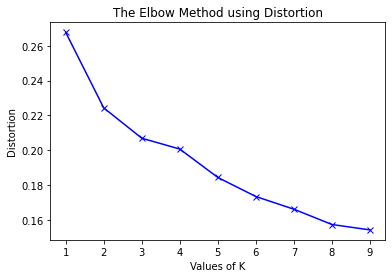

In [24]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Using the Elbow method we choose K=5.
Now we can proceed to fit the model.

In [25]:
preparing_data = cities_general_char.drop(['City'], 1)
k_clusters = 5

# run dbscan clustering
kmeans = KMeans(k_clusters).fit(preparing_data)


In [26]:
State_demographic_char.drop(State_demographic_char.loc[(State_demographic_char['City'] == 'Minatitlán') | (State_demographic_char['City'] == 'San Luis Río Colorado') | (State_demographic_char['City'] == 'Soledad')].index, 0, inplace=True)
clustered_data = pd.merge(cities_general_char, State_demographic_char[['City','latitude', 'longitude']], on='City').drop_duplicates('City')
#clustered_data.drop(['Cluster Labels'], axis=1, inplace=True)
#clustered_data.insert(0, 'Cluster Labels', kmeans.labels_)
clustered_data['Cluster Labels'] = np.array(kmeans.labels_)


In [27]:
clustered_data.head()


,City,Nominal daily income,2020 Census,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,...,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Village,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant,Zoo,latitude,longitude,Cluster Labels
0,Acapulco,0.134864,0.056454,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.01,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.09,0.01,0.01,0.0,0.01,0.0,0.0,0.00,...,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,16.868050,-99.894018,1
1,Aguascalientes,0.392071,0.079105,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.01,0.0,0.0,0.00,...,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,21.880655,-102.296132,0
2,Buenavista,0.436511,0.007703,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.00,0.0,0.03,0.0,0.0,0.00,0.0,0.05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,19.602237,-99.166381,0
3,Cabo San Lucas,0.301220,0.006149,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.00,0.01,0.0,0.00,0.0,0.0,0.01,0.0,0.07,0.0,0.0,0.0,0.0,0.03,0.00,0.00,0.0,0.00,0.0,0.0,0.01,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.01,22.893888,-109.920060,1
4,Campeche,0.735280,0.011327,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,18.144965,-91.029497,0


In [28]:
latitude = 23.634501
longitude = -102.552784

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered_data['latitude'], clustered_data['longitude'], clustered_data['City'], clustered_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clusters

cluster 0

Guadalajara is in this cluster.

In [30]:
clustered_data.loc[clustered_data['Cluster Labels'] == 0, clustered_data.columns[0]]

1               Aguascalientes
2                   Buenavista
4                     Campeche
7                       Chalco
9                  Chicoloapan
10                   Chihuahua
12                Chimalhuacán
13                Ciudad Acuña
14              Ciudad Apodaca
15        Ciudad Benito Juárez
16               Ciudad Juárez
17         Ciudad López Mateos
18               Ciudad Madero
19       Ciudad Nezahualcóyotl
20       Ciudad Nicolás Romero
22             Ciudad Victoria
24           Ciudad del Carmen
25               Coatzacoalcos
27          Cuautitlán Izcalli
28                     Cuautla
29                  Cuernavaca
32                    Ecatepec
33                    Ensenada
34                      García
35            General Escobedo
36                 Guadalajara
37                   Guadalupe
42                  Ixtapaluca
43                    Jiutepec
48                   Matamoros
50                    Mexicali
51                     Miramar
52      

cluster 1

In [31]:
clustered_data.loc[clustered_data['Cluster Labels'] == 1, clustered_data.columns[0]]

0                       Acapulco
3                 Cabo San Lucas
5                         Cancún
6                         Celaya
8                       Chetumal
11                  Chilpancingo
21                Ciudad Obregón
26                        Colima
30                      Culiacán
31                       Durango
39                 Gómez Palacio
40                    Hermosillo
41                      Irapuato
44                        La Paz
45                          León
46                    Los Mochis
47                    Manzanillo
49                      Mazatlán
54                       Morelia
55                        Mérida
59                        Oaxaca
61                       Pachuca
63              Playa del Carmen
65                        Puebla
69                     Salamanca
71    San Cristóbal de las Casas
80                      Tehuacán
81                         Tepic
88              Tuxtla Gutiérrez
89                       Uruapan
91        

cluster 2

In [32]:
clustered_data.loc[clustered_data['Cluster Labels'] == 2, clustered_data.columns[0]]

57    Nogales
Name: City, dtype: object

cluster 3

In [33]:
clustered_data.loc[clustered_data['Cluster Labels'] == 3, clustered_data.columns[0]]

79    Tapachula
Name: City, dtype: object



Given the original question and considering the fact that Guadalajara is in the cluster 0, I need to determinate whats is the best option to looking for a job.

The main characteristic will be the payment.


In [34]:
clustered_data[clustered_data['Cluster Labels'] == 0].sort_values("Nominal daily income", ascending=False).head()

,City,Nominal daily income,2020 Census,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,...,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Village,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant,Zoo,latitude,longitude,Cluster Labels
67,Querétaro,0.745298,0.071480,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.010000,0.0,0.0,0.050000,0.0,0.010000,0.0,0.00,0.0,0.0,0.00,0.0,0.010000,0.00,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,20.595471,-100.397059,0
73,San Juan del Río,0.745298,0.003393,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010526,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.031579,0.0,0.0,0.000000,0.0,0.021053,0.0,0.00,0.0,0.0,0.00,0.0,0.010526,0.00,0.010526,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.010526,0.0,0.0,0.00,0.0,0.0,0.00,0.010526,0.0,0.00,0.0,0.0,20.387046,-100.011963,0
24,Ciudad del Carmen,0.735280,0.004885,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.010000,0.0,0.0,0.000000,0.0,0.010000,0.0,0.01,0.0,0.0,0.03,0.0,0.010000,0.01,0.010000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.01,0.000000,0.0,0.01,0.0,0.0,18.651739,-91.814920,0
4,Campeche,0.735280,0.011327,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,18.144965,-91.029497,0
15,Ciudad Benito Juárez,0.725316,0.017800,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.083333,0.0,0.0,0.083333,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,25.646701,-100.090777,0


An the top 5 of similar Cities to Guadalajara with best payment are:
_Querétaro_, _San Juan del Río_, _Ciudad del Carmen_, _Campeche_ and _Ciudad Benito Juárez_.


## Conclusions

It is clear that exist a big number of possible cities offering a good job, but in this case, the collected information gives us an interesting result:

If only consider the payment, Ciudad de México is the best option but in this case, I need some city similar to my current live place and with good payment, therefore Queŕŕetaro, Querétaro is the best option.